In [1]:
# Import Libraries
import math
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load Data
data = pd.read_csv('fulldata.csv', index_col = 'Date')
data.shape

(2492, 50)

In [3]:
#Drop Sentiment Data
data = data.drop('vader_polarity', axis=1)

In [4]:
# Read over ARIMA predictions
%store -r full_arima_predictions

# Increment Indices
arima_predictions_list = full_arima_predictions.tolist()
arima_predictions_list.append(arima_predictions_list.pop(0))

# Append ARIMA predictions to dataframe
data['arima'] = arima_predictions_list

# Append close to dataframe
data['y'] = data['close_aapl']

In [5]:
#Data preview
data

,open_aapl,high_aapl,low_aapl,close_aapl,volume_aapl,open_googl,high_googl,low_googl,close_googl,volume_googl,...,macd,momentum,rsi_5,rsi_15,rsi_ratio,tr,atr,roc,arima,y
Date,,,,,,,,,,,,,,,,,,,,,
5/9/2013,16.421786,16.535714,16.270714,16.313214,398749904,21.792098,22.012812,21.726785,21.808114,87945080,...,0.329583,15.313214,66.171526,64.804242,1.021099,0.295000,0.419158,0.165081,16.313212,16.313214
5/10/2013,16.356071,16.418214,16.088572,16.177500,334849928,21.903956,22.034833,21.825130,22.027075,75955060,...,0.325128,15.177500,57.572386,61.822287,0.931256,0.329643,0.412934,0.159885,16.191360,16.177500
5/13/2013,16.125357,16.353572,16.125000,16.240714,317109240,21.993543,22.083127,21.855684,21.959510,57893080,...,0.322504,15.240714,60.556778,62.679325,0.966136,0.228572,0.404487,0.140643,16.231099,16.240714
5/14/2013,16.208928,16.257143,15.791071,15.852143,447115760,21.958759,22.238780,21.949751,22.198992,63190600,...,0.288120,14.852143,39.310535,54.606048,0.719893,0.466071,0.379742,0.092901,15.893159,15.852143
5/15/2013,15.684286,15.750000,15.084286,15.316071,741612360,22.409198,22.931701,22.372159,22.919439,159658020,...,0.218220,14.316071,24.492002,45.872465,0.533915,0.767857,0.412962,0.057682,15.359893,15.316071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3/27/2023,159.940000,160.770000,157.870000,158.280000,52390266,104.615000,104.760000,101.927300,102.460000,31120864,...,2.923728,157.280000,58.221301,60.577495,0.961104,2.900000,3.498250,0.028928,158.428987,158.280000
3/28/2023,157.970000,158.490000,155.980000,157.650000,45992152,102.440000,102.450000,99.740000,101.030000,32057865,...,2.811818,156.650000,53.185052,59.113390,0.899712,2.510000,3.543964,0.039908,157.627915,157.650000
3/29/2023,159.370000,161.050000,159.350000,160.770000,51305691,102.280000,102.490000,100.650000,101.390000,28779572,...,2.940983,159.770000,69.511345,63.760854,1.090188,3.400000,3.478964,0.051678,160.714492,160.770000


In [6]:
data.shape

(2492, 51)

In [7]:
# Convert data to numpy array
dataset = data.values

# Get training set size 80:20 split
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1994

In [8]:
# Scaler for data
scaler = MinMaxScaler(feature_range=(0,1))

In [10]:
# Create training dataset
train_data = dataset[0:training_data_len,:]

# Split to x_train and y_train
x_train = train_data[:,:50]
y_train = train_data[:,50]

# Create test dataset
test_data = dataset[training_data_len:,:]

# Split to x_test and y_test
x_test = test_data[:,:50]
y_test = test_data[:,50]

# Show shapes of sets
print('x_train shape: ' + str(x_train.shape))
print('y_train shape: ' + str(y_train.shape))
print()
print('x_test shape: ' + str(x_test.shape))
print('y_test shape: ' + str(y_test.shape))

x_train shape: (1994, 50)
y_train shape: (1994,)

x_test shape: (498, 50)
y_test shape: (498,)


In [11]:
# Convert training and testing sets to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Scale data
scaled_data = scaler.fit_transform(dataset)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train.reshape(-1,1))
x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test.reshape(-1,1))

x_train

array([[0.01885966, 0.01712881, 0.01868894, ..., 0.03001138, 0.78375968,
        0.01733483],
       [0.01835269, 0.01623046, 0.01726017, ..., 0.02908139, 0.77392832,
        0.01639152],
       [0.01657281, 0.01573623, 0.01754592, ..., 0.02781943, 0.73751712,
        0.01669916],
       ...,
       [0.86290998, 0.86872551, 0.87268769, ..., 0.36950964, 0.50650193,
        0.87993629],
       [0.88697981, 0.88761008, 0.89920129, ..., 0.3486992 , 0.55632543,
        0.8986756 ],
       [0.8935373 , 0.90787084, 0.90665333, ..., 0.36806892, 0.66708059,
        0.91915718]])

In [12]:
# Train Split Preview
print(x_train)
print(x_test)

# Test Split Preview
print(y_train)
print(y_test)

[[0.01885966 0.01712881 0.01868894 ... 0.03001138 0.78375968 0.01733483]
 [0.01835269 0.01623046 0.01726017 ... 0.02908139 0.77392832 0.01639152]
 [0.01657281 0.01573623 0.01754592 ... 0.02781943 0.73751712 0.01669916]
 ...
 [0.86290998 0.86872551 0.87268769 ... 0.36950964 0.50650193 0.87993629]
 [0.88697981 0.88761008 0.89920129 ... 0.3486992  0.55632543 0.8986756 ]
 [0.8935373  0.90787084 0.90665333 ... 0.36806892 0.66708059 0.91915718]]
[[0.15739028 0.14082333 0.14735361 ... 0.15673105 0.73666547 0.72379143]
 [0.15604506 0.17186964 0.17021277 ... 0.17602588 0.72425698 0.73813039]
 [0.19808307 0.17770154 0.16537718 ... 0.1834807  0.68942875 0.72892185]
 ...
 [0.60887843 0.6245283  0.65236504 ... 0.34200967 0.61482211 0.88487621]
 [0.64519926 0.64888508 0.68614384 ... 0.31817763 0.69149945 0.8934605 ]
 [0.66050109 0.6922813  0.69737999 ... 0.28382698 0.7849625  0.        ]]
[[0.01742606]
 [0.0163748 ]
 [0.01686447]
 ...
 [0.88179379]
 [0.90084931]
 [0.92126041]]
[[0.14297772]
 [0.1968

In [16]:
# Build autoencoder
# Code modified from: https://www.analyticsvidhya.com/blog/2021/06/dimensionality-reduction-using-autoencoders-in-python/
class AutoEncoders(Model):

    # Initializer
    def __init__(self, output_units):

        super().__init__()

        # Build Encoder down to 10 features
        self.encoder = Sequential(
            [
                Dense(50, activation="relu"),
                Dense(37, activation="relu"),
                Dense(25, activation="relu")
            ]
        )

        # Build Decoder
        self.decoder = Sequential(
            [
                Dense(37, activation="relu"),
                Dense(51, activation="relu"),
                Dense(output_units, activation="sigmoid")
            ]
        )

    # Call Overwrite
    def call(self, inputs):
        # Encode
        encoded = self.encoder(inputs)
        
        # Decode
        decoded = self.decoder(encoded)
        
        # Return
        return decoded
    
# Autoencoder Usage
    # Instantiate Autoencoder
auto_encoder = AutoEncoders(50)
    
    # Prep for training
auto_encoder.compile( loss='mae', metrics=['mae'], optimizer='adam')

    # Train
history = auto_encoder.fit(
    x_train, 
    x_train, 
    epochs=250, 
    batch_size=16, 
    validation_data=(x_test, x_test)
)


Epoch 1/250
125/125 [==============================] - 4s 8ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.1926 - val_mae: 0.1926
Epoch 2/250
125/125 [==============================] - 1s 5ms/step - loss: 0.0594 - mae: 0.0594 - val_loss: 0.1744 - val_mae: 0.1744
Epoch 3/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0466 - mae: 0.0466 - val_loss: 0.1555 - val_mae: 0.1555
Epoch 4/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0416 - mae: 0.0416 - val_loss: 0.1466 - val_mae: 0.1466
Epoch 5/250
125/125 [==============================] - 1s 9ms/step - loss: 0.0394 - mae: 0.0394 - val_loss: 0.1394 - val_mae: 0.1394
Epoch 6/250
125/125 [==============================] - 1s 5ms/step - loss: 0.0372 - mae: 0.0372 - val_loss: 0.1378 - val_mae: 0.1378
Epoch 7/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.1360 - val_mae: 0.1360
Epoch 8/250
125/125 [==============================] - 1s 6ms/step - 

125/125 [==============================] - 1s 8ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.1135 - val_mae: 0.1135
Epoch 63/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.1115 - val_mae: 0.1115
Epoch 64/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.1098 - val_mae: 0.1098
Epoch 65/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.1108 - val_mae: 0.1108
Epoch 66/250
125/125 [==============================] - 1s 8ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.1103 - val_mae: 0.1103
Epoch 67/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.1095 - val_mae: 0.1095
Epoch 68/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.1114 - val_mae: 0.1114
Epoch 69/250
125/125 [==============================] - 1s 4ms/step - loss:

125/125 [==============================] - 1s 8ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.1084 - val_mae: 0.1084
Epoch 124/250
125/125 [==============================] - 1s 8ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.1053 - val_mae: 0.1053
Epoch 125/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.1051 - val_mae: 0.1051
Epoch 126/250
125/125 [==============================] - 1s 8ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.1034 - val_mae: 0.1034
Epoch 127/250
125/125 [==============================] - 1s 8ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.1061 - val_mae: 0.1061
Epoch 128/250
125/125 [==============================] - 1s 6ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.1046 - val_mae: 0.1046
Epoch 129/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.1059 - val_mae: 0.1059
Epoch 130/250
125/125 [==============================] - 1s 6ms/step 

Epoch 184/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0957 - val_mae: 0.0957
Epoch 185/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0945 - val_mae: 0.0945
Epoch 186/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0959 - val_mae: 0.0959
Epoch 187/250
125/125 [==============================] - 1s 8ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0968 - val_mae: 0.0968
Epoch 188/250
125/125 [==============================] - 1s 5ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0968 - val_mae: 0.0968
Epoch 189/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0958 - val_mae: 0.0958
Epoch 190/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0961 - val_mae: 0.0961
Epoch 191/250
125/125 [==============================] 

125/125 [==============================] - 1s 6ms/step - loss: 0.0113 - mae: 0.0113 - val_loss: 0.0949 - val_mae: 0.0949
Epoch 245/250
125/125 [==============================] - 1s 6ms/step - loss: 0.0116 - mae: 0.0116 - val_loss: 0.0941 - val_mae: 0.0941
Epoch 246/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0118 - mae: 0.0118 - val_loss: 0.0922 - val_mae: 0.0922
Epoch 247/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0117 - mae: 0.0117 - val_loss: 0.0923 - val_mae: 0.0923
Epoch 248/250
125/125 [==============================] - 1s 6ms/step - loss: 0.0117 - mae: 0.0117 - val_loss: 0.0946 - val_mae: 0.0946
Epoch 249/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0116 - mae: 0.0116 - val_loss: 0.0945 - val_mae: 0.0945
Epoch 250/250
125/125 [==============================] - 1s 5ms/step - loss: 0.0117 - mae: 0.0117 - val_loss: 0.0932 - val_mae: 0.0932


In [18]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


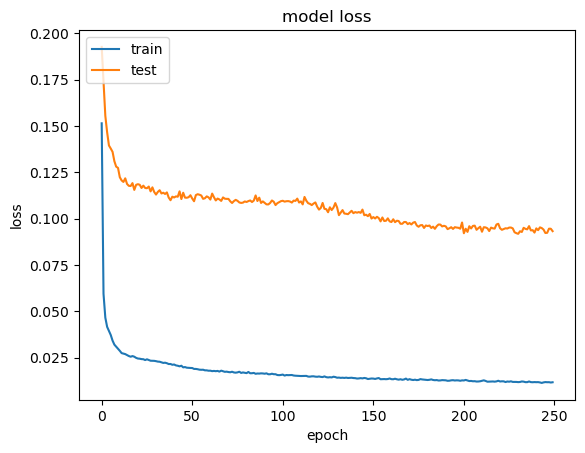

In [19]:
# Visualize Loss over Epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# Use encoder to compress feature set
encoder_layer = auto_encoder.get_layer('sequential_30')
compressed_x_train = encoder_layer.predict(x_train)
compressed_x_test = encoder_layer.predict(x_test)

ValueError: No such layer: sequential_30. Existing layers are: ['sequential_6', 'sequential_7'].

In [ ]:
reduced_x_train = pd.DataFrame(compressed_x_train)
reduced_x_train = reduced_x_train.add_prefix('feature_')
reduced_x_train

In [ ]:
reduced_x_test = pd.DataFrame(compressed_x_test)
reduced_x_test = reduced_x_test.add_prefix('feature_')
reduced_x_test

In [ ]:
# Store compressed feature set for use by wGAN-GP
%store compressed_x_train
%store compressed_x_test